# Exploring the poor skill relative to climatology and persistence of the EHF over much of Australia

In [92]:
import numpy as np

import xarray as xr

import dask

import matplotlib as mpl
import matplotlib.pyplot as plt

dask.config.set(**{"array.slicing.split_large_chunks": False})

from src import utils, verify, plot

In [93]:
mpl.rcParams["figure.figsize"] = (15, 5.5)

In [2]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [3]:
msss_clim = xr.open_zarr(
    "../../data/skill/CAFEf6.AGCD.annual.days_over_0.ehf_severity_Aus.MSSS_clim_1991-2020.zarr"
)
msss_pers = xr.open_zarr(
    "../../data/skill/CAFEf6.AGCD.annual.days_over_0.ehf_severity_Aus.MSSS_pers_1991-2020.zarr"
)

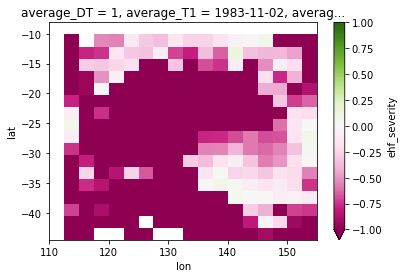

In [4]:
msss_clim["ehf_severity"].isel(lead=1).plot(vmin=-1, vmax=1, cmap="PiYG")

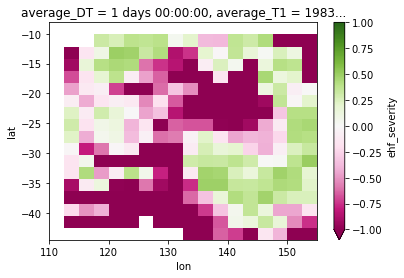

In [5]:
msss_pers["ehf_severity"].isel(lead=1).plot(vmin=-1, vmax=1, cmap="PiYG")

## Explore the timeseries

In [25]:
hindcast = xr.open_zarr(
    "../../data/processed/CAFEf6.annual.days_over_0.ehf_severity_Aus.zarr"
)
observation = xr.open_zarr(
    "../../data/processed/AGCD.annual.days_over_0.ehf_severity_Aus.zarr"
)

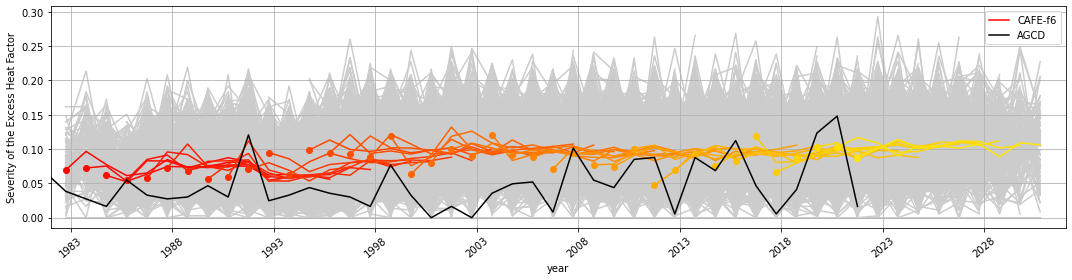

In [26]:
loc = {"lon": 125, "lat": -25}

_ = plot.hindcasts(
    {"CAFE-f6": hindcast.sel(loc, method="nearest").compute()},
    {"AGCD": observation.sel(loc, method="nearest").compute()},
)

# Let's look at annual bias-corrected `t_ref` skill for Australia

In [8]:
from dask.distributed import Client
from dask_jobqueue import PBSCluster

walltime = "02:00:00"
cores = 48
memory = "192GB"
cluster = PBSCluster(
    processes=1,
    walltime=str(walltime),
    cores=cores,
    memory=str(memory),
    job_extra=[
        "-q express",
        "-l ncpus=" + str(cores),
        "-l mem=" + str(memory),
        "-P xv83",
        "-l jobfs=100GB",
        "-l storage=gdata/xv83+gdata/oi10+gdata/ua8",
    ],
    local_directory="$PBS_JOBFS",
    header_skip=["select"],
)

cluster.scale(jobs=1)
client = Client(cluster)
print(f"Dask daskboard link: {client.dashboard_link}")

/g/data/xv83/users/ds0092/software/miniconda3/envs/forecast_analysis/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile
/g/data/xv83/users/ds0092/software/miniconda3/envs/forecast_analysis/lib/python3.9/site-packages/distributed/node.py:180: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45169 instead
  warnings.warn(


Dask daskboard link: http://10.6.56.58:45169/status


In [27]:
hindcast = xr.open_zarr(
    "../../data/processed/CAFEf6.daily.abc_1991-2020.t_ref_Aus.zarr",
    decode_timedelta=False,
)
observation = xr.open_zarr("../../data/processed/AGCD.daily.full.t_ref_Aus.zarr")

In [28]:
hindcast_annual = utils.coarsen(hindcast, window_size=365, dim="lead").compute()
observation_annual = utils.coarsen(
    observation, window_size=365, start_points=["1960-11-01"], dim="time"
)

In [29]:
msss_clim = verify.calculate_metric(
    hindcast_annual, observation_annual, metric="msss", reference="climatology"
)
msss_pers = verify.calculate_metric(
    hindcast_annual, observation_annual, metric="msss", reference="persistence"
)

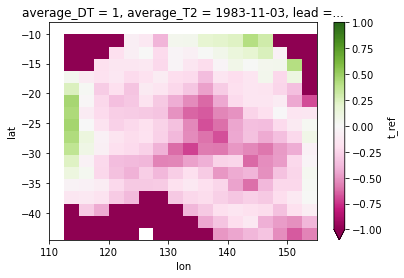

In [30]:
msss_clim["t_ref"].isel(lead=1).plot(vmin=-1, vmax=1, cmap="PiYG")

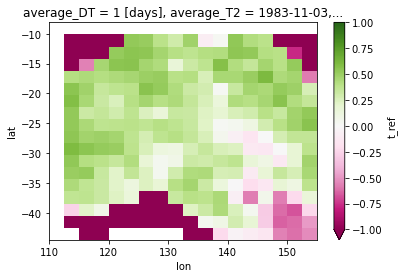

In [31]:
msss_pers["t_ref"].isel(lead=1).plot(vmin=-1, vmax=1, cmap="PiYG")

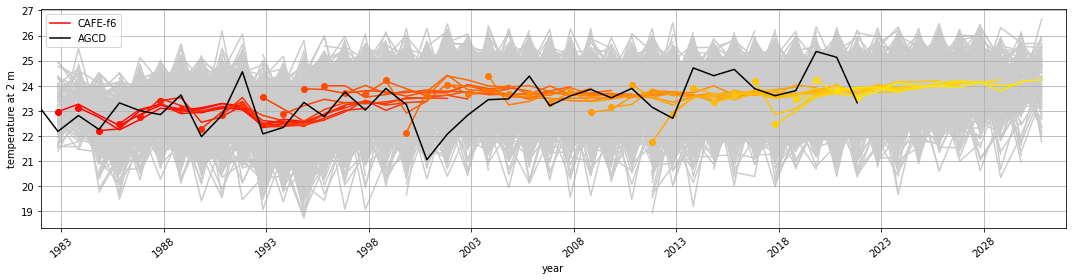

In [32]:
loc = {"lon": 125, "lat": -25}

_ = plot.hindcasts(
    {"CAFE-f6": hindcast_annual.sel(loc, method="nearest").compute()},
    {"AGCD": observation_annual.sel(loc, method="nearest").compute()},
)

# Let's look at annual mean `ehf_severity` skill for Australia

In [33]:
hindcast = xr.open_zarr(
    "../../data/processed/CAFEf6.daily.full.ehf_severity_Aus.zarr",
    decode_timedelta=False,
)
observation = xr.open_zarr("../../data/processed/AGCD.daily.full.ehf_severity_Aus.zarr")

In [34]:
hindcast_annual = utils.coarsen(hindcast, window_size=365, dim="lead").compute()
observation_annual = utils.coarsen(
    observation, window_size=365, start_points=["1960-11-01"], dim="time"
)

In [35]:
msss_clim = verify.calculate_metric(
    hindcast_annual, observation_annual, metric="msss", reference="climatology"
)
msss_pers = verify.calculate_metric(
    hindcast_annual, observation_annual, metric="msss", reference="persistence"
)

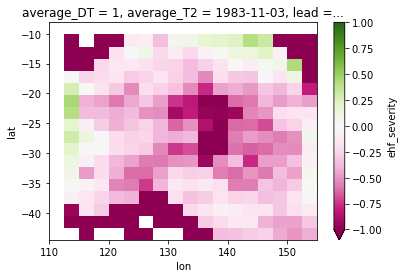

In [90]:
msss_clim["ehf_severity"].isel(lead=1).plot(vmin=-1, vmax=1, cmap="PiYG")

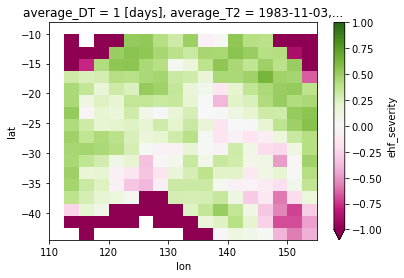

In [37]:
msss_pers["ehf_severity"].isel(lead=1).plot(vmin=-1, vmax=1, cmap="PiYG")

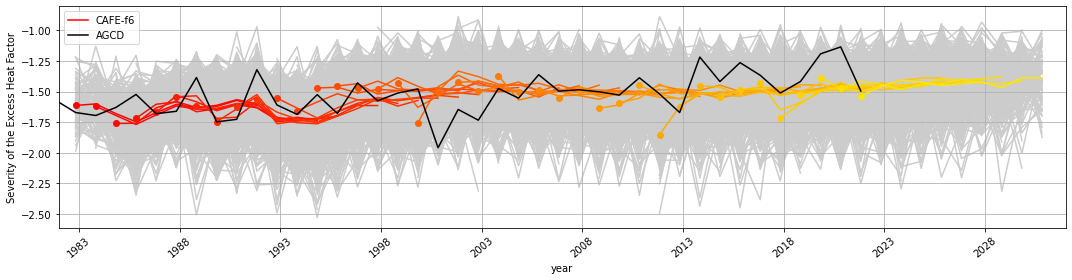

In [38]:
loc = {"lon": 125, "lat": -25}

_ = plot.hindcasts(
    {"CAFE-f6": hindcast_annual.sel(loc, method="nearest").compute()},
    {"AGCD": observation_annual.sel(loc, method="nearest").compute()},
)

# So the mean `ehf_severity` skill follows generally the `t_ref` skill, but the number of days > 0 is quite a bit worse. This implies the shape of the distribution is off. Let's look at the distribution of the `ehf_severity`

In [87]:
loc = {"lon": 125, "lat": -25}
period = ["1991-01-01", "2020-12-31"]

In [95]:
o = utils.keep_period(observation.sel(loc, method="nearest"), period)[
    "ehf_severity"
].values

h = utils.keep_period(
    hindcast.isel(lead=slice(0, 365)).sel(loc, method="nearest"),
    period,
)["ehf_severity"].values.flatten()

h = h[~np.isnan(h)]

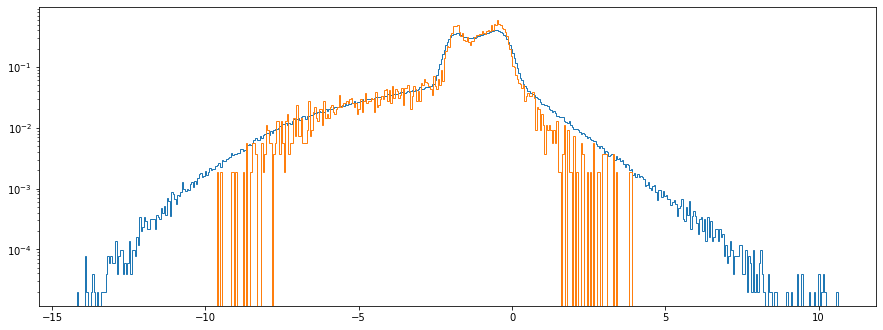

In [96]:
import matplotlib.pyplot as plt

bins = np.histogram(np.hstack((o, h)), bins=500)[1]  # get the bin edges

plt.hist(h, bins, density=True, histtype="step")
_ = plt.hist(o, bins, density=True, histtype="step")

plt.yscale("log")

# Could adjusting the variance help?

In [99]:
cluster.close()
client.close()